In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf

from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [4]:
train_dataset = pd.read_csv('/kaggle/input/optiver-trading-at-the-close/train.csv')
train_dataset.shape

(5237980, 17)

In [5]:
train_dataset.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4


# Explore the dataset

In [6]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5237980 entries, 0 to 5237979
Data columns (total 17 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   stock_id                 int64  
 1   date_id                  int64  
 2   seconds_in_bucket        int64  
 3   imbalance_size           float64
 4   imbalance_buy_sell_flag  int64  
 5   reference_price          float64
 6   matched_size             float64
 7   far_price                float64
 8   near_price               float64
 9   bid_price                float64
 10  bid_size                 float64
 11  ask_price                float64
 12  ask_size                 float64
 13  wap                      float64
 14  target                   float64
 15  time_id                  int64  
 16  row_id                   object 
dtypes: float64(11), int64(5), object(1)
memory usage: 679.4+ MB


In [7]:
train_dataset.isna().sum()

stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                 220
imbalance_buy_sell_flag          0
reference_price                220
matched_size                   220
far_price                  2894342
near_price                 2857180
bid_price                      220
bid_size                         0
ask_price                      220
ask_size                         0
wap                            220
target                          88
time_id                          0
row_id                           0
dtype: int64

In [8]:
train_dataset[['far_price', 'near_price']].describe()

,far_price,near_price
count,2.343638e+06,2.380800e+06
mean,1.001713e+00,9.996601e-01
std,7.214705e-01,1.216920e-02
min,7.700000e-05,7.869880e-01
25%,9.963320e-01,9.971000e-01
50%,9.998830e-01,9.998890e-01
75%,1.003318e+00,1.002590e+00
max,4.379531e+02,1.309732e+00


### Fill missing values in *near_price* following a custom distribution

<Axes: xlabel='near_price', ylabel='Density'>

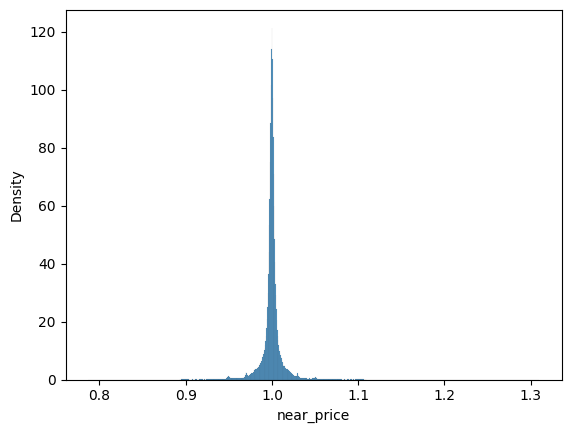

In [9]:
sns.histplot(x=train_dataset.near_price, stat='density', bins=1000)

/tmp/ipykernel_20/3568801770.py:10: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  ydata, xdata = np.histogram(near_price_norm, bins=1000, normed=True)


Text(0.5, 0, 'Normalized near price')

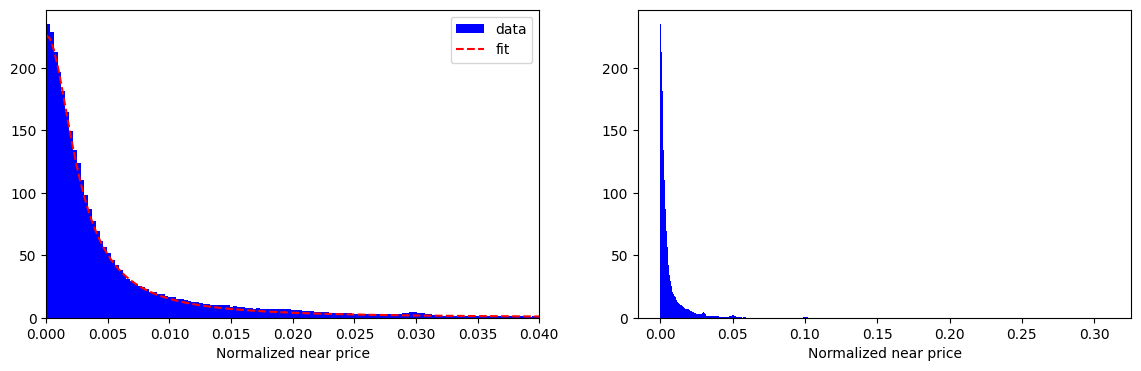

In [10]:
from scipy.optimize import curve_fit 

# Define the Gaussian function 
def near_price_fit(x, A, B): 
    y = 1/(A + (B*x)**2)
    return y 

near_price_norm = abs(train_dataset.near_price - train_dataset.near_price.mean()).dropna()

ydata, xdata = np.histogram(near_price_norm, bins=1000, normed=True)
parameters, covariance = curve_fit(near_price_fit, xdata[:-1], ydata) 
fit_A_near = parameters[0] 
fit_B_near = parameters[1]
fit = near_price_fit(xdata, fit_A_near, fit_B_near)

plt.figure(figsize=(14,4))
plt.subplot(121)
plt.hist(near_price_norm, bins=1000, label='data', density=True, color='blue') 
plt.plot(xdata, fit, 'r--', label='fit') 
plt.xlabel('Normalized near price')
plt.xlim((0,0.04))
plt.legend()
plt.subplot(122)
plt.hist(near_price_norm, bins=1000, label='data', density=True, color='blue') 
plt.xlabel('Normalized near price')

In [11]:
# train_dataset['near_price_norm'] = abs(train_dataset.near_price - train_dataset.near_price.mean())
train_dataset['near_price_norm'] = train_dataset.near_price
N_near_price = train_dataset['near_price_norm'].isna().sum()
x = np.arange(-1.3, 1.3, step=0.00001)
prob = near_price_fit(x, fit_A_near, fit_B_near)
train_dataset.loc[train_dataset['near_price_norm'].isna(), 'near_price_norm'] = random.choices(x, weights=prob, k=N_near_price)
# train_dataset['near_price'] = train_dataset['near_price'].fillna(train_dataset['near_price'].mean())
train_dataset.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id,near_price_norm
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0,-0.00051
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1,0.00819
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2,0.00019
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3,0.00214
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4,0.00049


In [12]:
train_dataset.isna().sum()

stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                 220
imbalance_buy_sell_flag          0
reference_price                220
matched_size                   220
far_price                  2894342
near_price                 2857180
bid_price                      220
bid_size                         0
ask_price                      220
ask_size                         0
wap                            220
target                          88
time_id                          0
row_id                           0
near_price_norm                  0
dtype: int64

### Fill missing values in *far_price* following a custom distribution

<Axes: xlabel='far_price', ylabel='Density'>

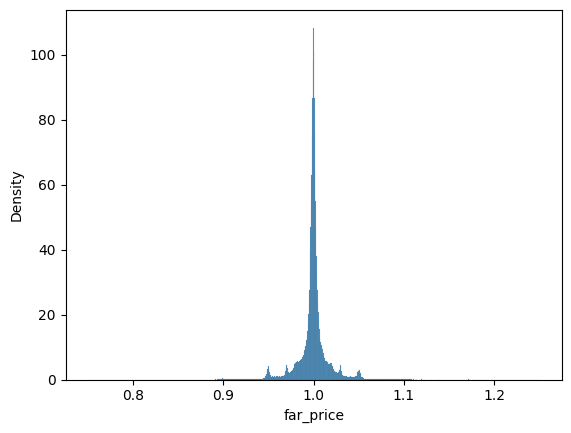

In [13]:
sns.histplot(x=train_dataset[(train_dataset.far_price > 0.75) & (train_dataset.far_price < 1.25)].far_price, stat='density', bins=1000)

/tmp/ipykernel_20/2661713856.py:11: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  ydata, xdata = np.histogram(far_price_norm, bins=1000, normed=True)


Text(0.5, 0, 'Normalized far price')

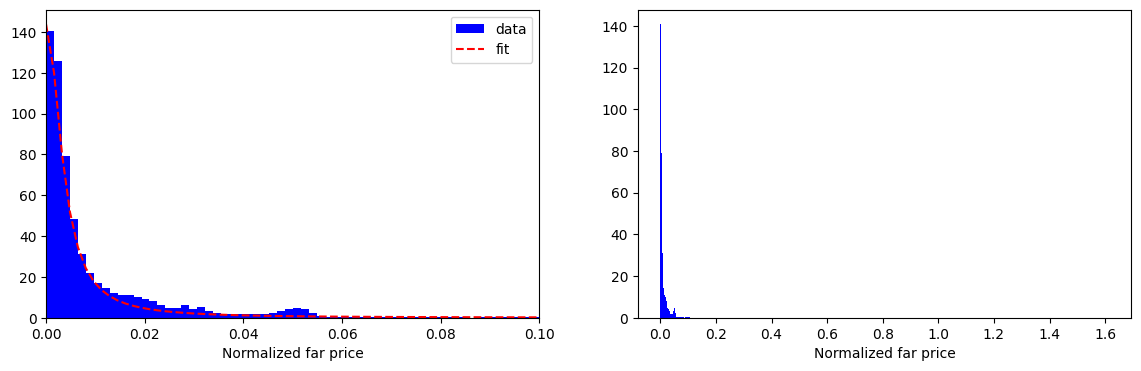

In [14]:
from scipy.optimize import curve_fit 

# Define the Gaussian function 
def far_price_fit(x, A, B): 
    y = 1/(A + (B*x)**2)
    return y 

far_price_norm = abs(train_dataset.far_price - train_dataset.far_price.mean()).dropna()
far_price_norm = far_price_norm[far_price_norm < 2]

ydata, xdata = np.histogram(far_price_norm, bins=1000, normed=True)
parameters, covariance = curve_fit(far_price_fit, xdata[:-1], ydata) 
fit_A_far = parameters[0] 
fit_B_far = parameters[1]
fit = far_price_fit(xdata, fit_A_far, fit_B_far)

plt.figure(figsize=(14,4))
plt.subplot(121)
plt.hist(far_price_norm, bins=1000, label='data', density=True, color='blue') 
plt.plot(xdata, fit, 'r--', label='fit') 
plt.xlabel('Normalized far price')
plt.xlim((0, 0.1))
plt.legend()
plt.subplot(122)
plt.hist(far_price_norm, bins=1000, label='data', density=True, color='blue') 
plt.xlabel('Normalized far price')

In [15]:
# train_dataset['far_price_norm'] = abs(train_dataset.far_price - train_dataset.far_price.mean())
train_dataset['far_price_norm'] = train_dataset.far_price
N_far_price = train_dataset['far_price_norm'].isna().sum()
x = np.arange(-1.3, 1.3, step=0.00001)
prob = far_price_fit(x, fit_A_far, fit_B_far)
train_dataset.loc[train_dataset['far_price_norm'].isna(), 'far_price_norm'] = random.choices(x, weights=prob, k=N_far_price)
# train_dataset['far_price'] = train_dataset['far_price'].fillna(train_dataset['far_price'].mean())
train_dataset.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id,near_price_norm,far_price_norm
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0,-0.00051,0.00732
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1,0.00819,-0.00167
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2,0.00019,-0.00006
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3,0.00214,-0.00456
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4,0.00049,-0.00419


### Explore the remaining features

<Axes: xlabel='imbalance_buy_sell_flag', ylabel='Density'>

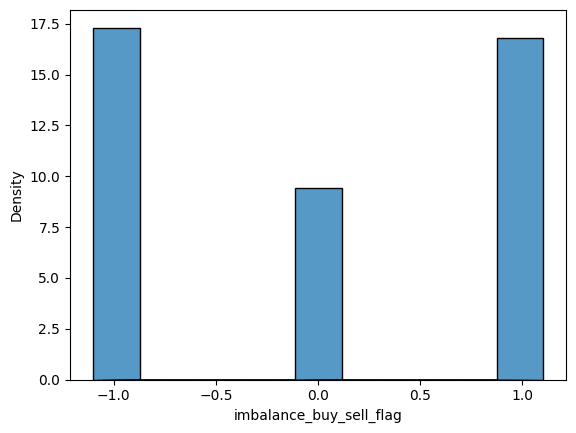

In [16]:
sns.histplot(x=train_dataset.imbalance_buy_sell_flag, shrink=10, stat='density')

<Axes: xlabel='date_id', ylabel='wap'>

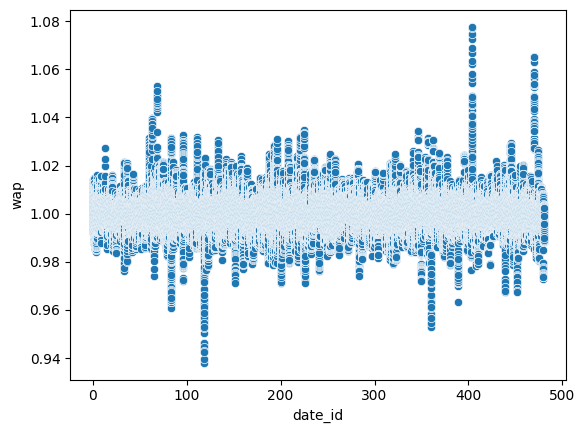

In [17]:
sns.scatterplot(x=train_dataset.date_id, y=train_dataset.wap)

<Axes: xlabel='wap', ylabel='target'>

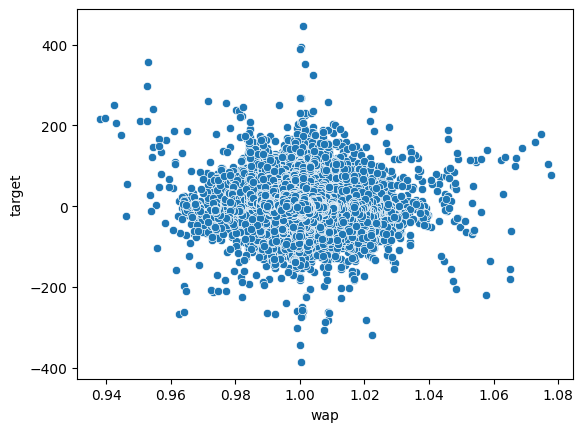

In [18]:
sns.scatterplot(x=train_dataset.wap, y=train_dataset.target)

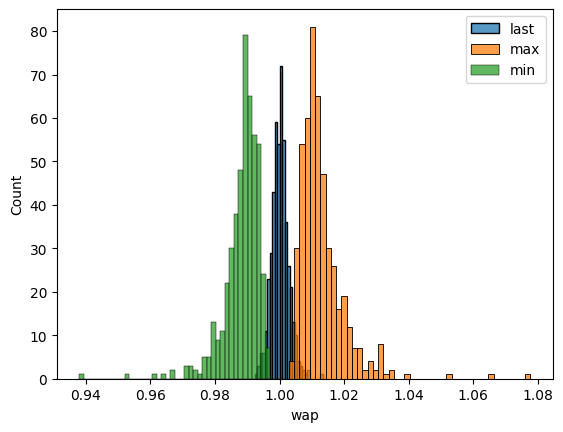

In [19]:
# sns.histplot(x=train_dataset.groupby('date_id').first().near_price)
sns.histplot(x=train_dataset.groupby('date_id').last().wap, label='last')
sns.histplot(x=train_dataset.groupby('date_id').wap.max(), label='max')
sns.histplot(x=train_dataset.groupby('date_id').wap.min(), label='min')
plt.legend()

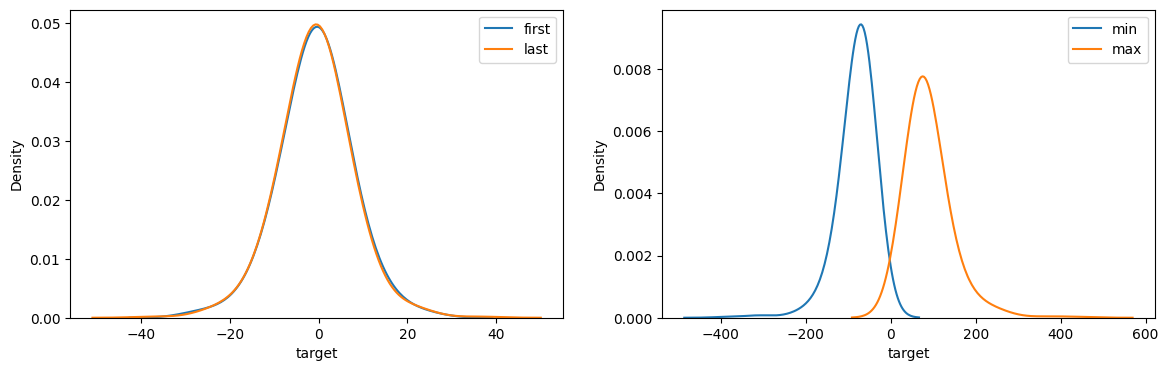

In [20]:
plt.figure(figsize=(14,4))
plt.subplot(121)
sns.kdeplot(x=train_dataset.groupby('date_id').target.first(), bw_adjust=2, label='first')
sns.kdeplot(x=train_dataset.groupby('date_id').target.last(), bw_adjust=2, label='last')
plt.legend()
plt.subplot(122)
sns.kdeplot(x=train_dataset.groupby('date_id').target.min(), bw_adjust=3, label='min')
sns.kdeplot(x=train_dataset.groupby('date_id').target.max(), bw_adjust=3, label='max')
plt.legend()

<Axes: xlabel='target', ylabel='Density'>

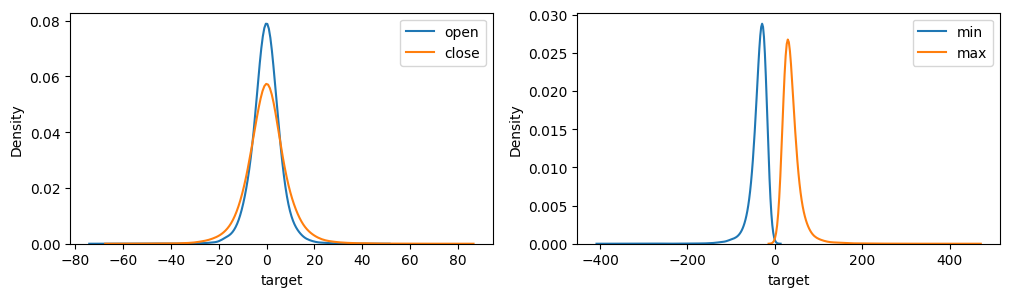

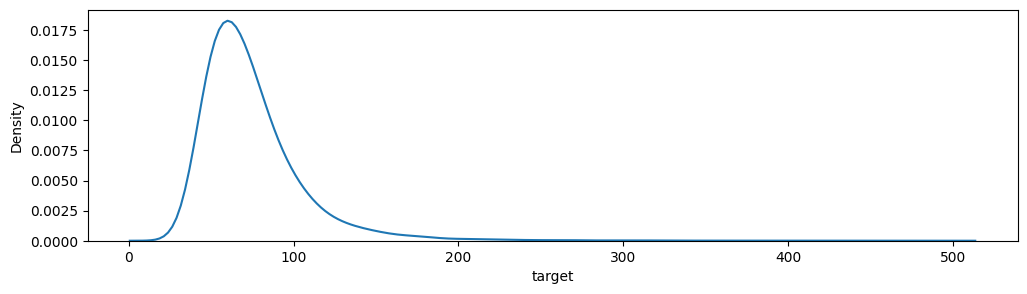

In [21]:
plt.figure(figsize=(12,3))
plt.subplot(121)
sns.kdeplot(x=train_dataset.groupby('time_id').target.first(), bw_adjust=2, label='open')
sns.kdeplot(x=train_dataset.groupby('time_id').target.last(), bw_adjust=2, label='close')
plt.legend()
plt.subplot(122)
sns.kdeplot(x=train_dataset.groupby('time_id').target.min(), bw_adjust=3, label='min')
sns.kdeplot(x=train_dataset.groupby('time_id').target.max(), bw_adjust=3, label='max')
plt.legend()
plt.figure(figsize=(12,3))
sns.kdeplot(x=train_dataset.groupby('time_id').target.max() - train_dataset.groupby('time_id').target.min(), bw_adjust=2, label='max - min')

# Features selection

In [22]:
train_dataset['volume'] = train_dataset['ask_size'] + train_dataset['bid_size']

train_dataset['ask_ref_ratio'] = train_dataset['ask_price']/train_dataset['reference_price']
train_dataset['bid_ref_ratio'] = train_dataset['bid_price']/train_dataset['reference_price']

train_dataset['ask_imb_ratio'] = train_dataset['ask_size']/train_dataset['imbalance_size']
train_dataset['bid_imb_ratio'] = train_dataset['bid_size']/train_dataset['imbalance_size']

train_dataset['ask_mat_ratio'] = train_dataset['ask_size']/train_dataset['matched_size']
train_dataset['bid_mat_ratio'] = train_dataset['bid_size']/train_dataset['matched_size']

In [23]:
features = ['imbalance_size', 'imbalance_buy_sell_flag', 'reference_price', 'matched_size', 
            'bid_price', 'bid_size', 'ask_price', 'ask_size', 'wap']#, 'near_price_norm', 'far_price_norm',
#             'volume', 'ask_ref_ratio', 'bid_ref_ratio', 'ask_imb_ratio', 'bid_imb_ratio', 'ask_mat_ratio', 'bid_mat_ratio']
# features = ['imbalance_size', 'imbalance_buy_sell_flag', 'reference_price', 'matched_size', 
#             'bid_price', 'bid_size', 'ask_price', 'ask_size', 'wap', 'near_price', 'far_price']

# Build model

In [24]:
train_dataset_drop = train_dataset[features+['target']].dropna()
X = train_dataset_drop.drop(columns='target')
y = train_dataset_drop[['target']]

In [25]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.5)

In [26]:
callbacks_list = [tf.keras.callbacks.EarlyStopping(
                  monitor='val_loss',
                  restore_best_weights=True,
                  patience=5)] 

In [27]:
# model_pre = LGBMRegressor()
# model_pre.fit(X, y)
# X_new = X.copy()
# X_new['target_pred'] = model_pre.predict(X)
# mean_absolute_error(X_new.target_pred, y)
# weights = model_pre.class_weight

In [28]:
def create_model(X, y):
    
    input_layer = tf.keras.Input(shape=(X.shape[1], ))
    
    x = tf.keras.layers.BatchNormalization()(input_layer)
#     x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)    
    x = tf.keras.layers.Dense(64, activation='relu')(x)

    
    output_layer = tf.keras.layers.Dense(y.shape[1])(x)
    
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.MeanAbsoluteError())
    
    return model

model = create_model(X, y)
model.fit(X, y, 
          epochs=20, 
          batch_size=1024,
#           steps_per_epoch=100,
          callbacks=callbacks_list,
          validation_split=0.05)

Epoch 1/20
4860/4860 [==============================] - 39s 8ms/step - loss: 6.3602 - val_loss: 5.9232
Epoch 2/20
4860/4860 [==============================] - 36s 7ms/step - loss: 6.3308 - val_loss: 5.9173
Epoch 3/20
4860/4860 [==============================] - 36s 7ms/step - loss: 6.3264 - val_loss: 5.9043
Epoch 4/20
4860/4860 [==============================] - 36s 7ms/step - loss: 6.3249 - val_loss: 5.9137
Epoch 5/20
4860/4860 [==============================] - 36s 7ms/step - loss: 6.3231 - val_loss: 5.9113
Epoch 6/20
4860/4860 [==============================] - 35s 7ms/step - loss: 6.3221 - val_loss: 5.9050
Epoch 7/20
4860/4860 [==============================] - 36s 7ms/step - loss: 6.3214 - val_loss: 5.9133
Epoch 8/20
4860/4860 [==============================] - 35s 7ms/step - loss: 6.3203 - val_loss: 5.9226


In [29]:
# model = LGBMRegressor(objective='mae',
#                       random_seed = 123,
#                       n_estimators = 500,
#                       learning_rate = 0.018,
#                       num_leaves = 440,
#                       reg_alpha = 0.01,
#                       reg_lambda =  0.01,
#                       max_depth= 9)
# model.fit(X, y)

# Submission

In [30]:
test_dataset = pd.read_csv('/kaggle/input/optiver-trading-at-the-close/example_test_files/test.csv')
test_dataset.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,time_id,row_id,currently_scored
0,0,478,0,3753451.43,-1,0.999875,11548975.43,NaN,NaN,0.999875,22940.00,1.000050,9177.60,1.0,26290,478_0_0,False
1,1,478,0,985977.11,-1,1.000245,3850033.97,NaN,NaN,0.999940,1967.90,1.000601,19692.00,1.0,26290,478_0_1,False
2,2,478,0,599128.74,1,1.000584,4359198.25,NaN,NaN,0.999918,4488.22,1.000636,34955.12,1.0,26290,478_0_2,False
3,3,478,0,2872317.54,-1,0.999802,27129551.64,NaN,NaN,0.999705,16082.04,1.000189,10314.00,1.0,26290,478_0_3,False
4,4,478,0,740059.14,-1,0.999886,8880890.78,NaN,NaN,0.999720,19012.35,1.000107,7245.60,1.0,26290,478_0_4,False


In [31]:
predictions = model.predict(test_dataset[features])

1032/1032 [==============================] - 2s 1ms/step


In [32]:
predictions

array([[-0.6465058 ],
       [ 1.9482435 ],
       [ 2.2507095 ],
       ...,
       [ 0.2566326 ],
       [ 0.14488587],
       [-0.26287574]], dtype=float32)

In [33]:
import optiver2023
env = optiver2023.make_env()
iter_test = env.iter_test()

In [34]:
counter = 0
# env.predict(test)
for (test, revealed_targets, sample_prediction) in iter_test:
    if counter == 0:
        print(test.head(3))
        print(revealed_targets.head(3))
        print(sample_prediction.head(3))

#     test['near_price_norm'] = abs(test.near_price - test.near_price.mean())
#     test['near_price_norm'] = test.near_price
#     N_near_price = test['near_price_norm'].isna().sum()
#     x = np.arange(0, 0.3, step=0.0001)
#     prob = near_price_fit(x, fit_A_near, fit_B_near)
#     test.loc[test['near_price_norm'].isna(), 'near_price_norm'] = random.choices(x, weights=prob, k=N_near_price)
    
# #     test['far_price_norm'] = abs(test.far_price - test.far_price.mean())
#     test['far_price_norm'] = test.far_price
#     N_far_price = test['far_price_norm'].isna().sum()
#     x = np.arange(0, 0.3, step=0.0001)
#     prob = far_price_fit(x, fit_A_far, fit_B_far)
#     test.loc[test['far_price_norm'].isna(), 'far_price_norm'] = random.choices(x, weights=prob, k=N_far_price)
    
#     test['volume'] = test['ask_size'] + test['bid_size']
#     test['ask_ref_ratio'] = test['ask_price']/test['reference_price']
#     test['bid_ref_ratio'] = test['bid_price']/test['reference_price']
    
#     test['ask_imb_ratio'] = test['ask_size']/test['imbalance_size']
#     test['bid_imb_ratio'] = test['bid_size']/test['imbalance_size']

#     test['ask_mat_ratio'] = test['ask_size']/test['matched_size']
#     test['bid_mat_ratio'] = test['bid_size']/test['matched_size']

#     test['far_price'] = test['far_price'].fillna(test['far_price'].mean())
#     test['near_price'] = test['near_price'].fillna(test['near_price'].mean())
#     pd.set_option('mode.use_inf_as_na', True)  

#     test_new = test[features].copy()
#     test_new['target_pred'] = model_pre.predict(test[features])
#     test_new = test_new.fillna('median')
    
#     sample_prediction['target'] = pd.Series(model.predict(test_new).ravel()).astype('float64').values
    sample_prediction['target'] = model.predict(test[features])
    
    env.predict(sample_prediction)
    counter += 1

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
   stock_id  date_id  seconds_in_bucket  imbalance_size  \
0         0      478                  0      3753451.43   
1         1      478                  0       985977.11   
2         2      478                  0       599128.74   

   imbalance_buy_sell_flag  reference_price  matched_size  far_price  \
0                       -1         0.999875   11548975.43        NaN   
1                       -1         1.000245    3850033.97        NaN   
2                        1         1.000584    4359198.25        NaN   

   near_price  bid_price  bid_size  ask_price  ask_size  wap   row_id  \
0         NaN   0.999875  22940.00   1.000050   9177.60  1.0  478_0_0   
1         NaN   0.999940   1967.90   1.000601  19692.00  1.0  478_0_1   
2         NaN   0.999918   4488.22   1.000636  34955.12  1.0  478_0_2   

   currently_scored  
0             False  
1           